In [4]:
# This version of the SVD fits using states expressed as excitations relative to a nuclear ground state
import random
import math
import scipy.linalg
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.linewidth'] = 2.0
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv
from scipy import stats
from IPython.display import Image

# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()
dataIn = pd.read_fwf('exp.dai', header=None).to_numpy()
nuclei = dataIn[:,6]

# extract the SPEs and TBME's for the ab initio (rem38f) interaction and starting interaction for fit (r35c)
abinitioHam = energyDF[0,6:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
error = energyDF[2:,3]

expWeighted = np.empty([len(exp)])     # Experimental values divided by their errors
for i in range(len(exp)):
    expWeighted[i] = exp[i]/error[i]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian in terms of excited states
betas = np.empty([len(exp),len(abinitioHam)])
for i in range(len(exp)):
    for j in range(len(abinitioHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+6]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+6] - gsContributions[j]

# Construct the transposed Jacobian matrix from the betas and errors
JacobianT = np.empty([len(exp), len(abinitioHam)])
for i in range(len(exp)):
    JacobianT[i] = betas[i]/error[i]

numData = 0
groundStates = 0
for i in range(len(error)):
    if error[i] <= 1.0:
        numData += 1
        if exp[i] <= 0.0:
            groundStates +=1

print(numData, 'states included in fit with ', groundStates, 'ground states.')

182 states included in fit with  22 ground states.


In [3]:
# This segment iterates (numBatches times) over randomized batches of the available data (including all ground states)
# All excited states from 79Cu to 99In are available for building training batches
# The full dataset is used for testing

def allVLC(numBatches, dataPercent, numVLC):
    # numBatches is how many randomized batches of experimental data to use in the fit
    # dataPercent is the percentage of the total known data to include in the fit, the rest are test data

    eRMSRangeAll = np.empty([numBatches,len(abinitioHam)+1])      # arrays for storing energy root-mean-squared-error
    eRMSRangeTest = np.empty([numBatches,len(abinitioHam)+1])
    eRMSRangeTrain = np.empty([numBatches,len(abinitioHam)+1])
    pRMSRange = np.empty([numBatches, len(abinitioHam)+1])        # array for storing parameter RMSE
    eVLC = []                                                     # list for storying energy spectra of numVLC SVD
    for b in range(numBatches):
        # Select a random batch of data to fit the parameters to (making sure that ground states are always included in the batch)
        batchChoice = np.zeros(len(exp))
        random.seed()
        for i in range(len(exp)):
            if exp[i] <= 0.0:
                batchChoice[i] = 1
            else:
                k = random.random()
                if k >= 1-dataPercent:
                    batchChoice[i] = 1

        batchExpWeighted = np.empty(int(np.sum(batchChoice)))
        batchJacobian = np.empty([len(batchExpWeighted), len(abinitioHam)])
        batchIndex = 0
        for i in range(len(exp)):
            if batchChoice[i] == 1:
                batchExpWeighted[batchIndex] = expWeighted[i]
                batchJacobian[batchIndex] = JacobianT[i]
                batchIndex += 1
                     
        # Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
        e = np.empty(len(abinitioHam))
        G = np.empty((len(abinitioHam),len(abinitioHam)))
        for i in range(len(abinitioHam)):           # Contructing data vector (e)
            e[i] = np.dot(batchExpWeighted, batchJacobian[:,i])
        for i in range(len(abinitioHam)):           # Constructing design matrix (G)
            for j in range(i+1):
                G[i,j] = G[j,i] = np.dot(batchJacobian[:,i],batchJacobian[:,j])    # G is a symmetric matrix        

        # Here we perform an SVD of our design matrix and invert the singular values (in S)
        # to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
        U, Svec, Ut = np.linalg.svd(G)
        # Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
        # e and p into new vectors c and y, respectively
        c = np.dot(Ut,e)
        y = np.dot(Ut,abinitioHam)

        # This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
        # at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
        for i in range(len(abinitioHam)+1):
            yfit = np.empty(len(abinitioHam))
            fitParameters = np.empty(len(abinitioHam))      # Array for storing fitted parameters in this iteration                           
            eResidualTest = []                              # List for storing residuals for RMSE calculation
            eResidualTrain = []
            for j in range(len(abinitioHam)):
                if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
                    yfit[j] = c[j]/Svec[j]
                elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
                    yfit[j] = y[j]
            fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
            for j in range(len(exp)):  
                eFitTot = np.dot(fitParameters, betas[j])       # Modify our initial energy contributions to state j by new weights
                if i == numVLC:
                    eVLC.append(eFitTot)
                    #if exp[j] <= 0.0:
                        #eVLC[j] -= 642.564            
                if error[j] <= 1.0:
                    if batchChoice[j] ==1:
                        eResidualTrain.append(exp[j]-eFitTot)
                    elif batchChoice[j] == 0:
                        eResidualTest.append(exp[j]-eFitTot)
            trainArray = np.array(eResidualTrain)                   # Convert lists back to arrays
            testArray = np.array(eResidualTest)
            pResidual = abinitioHam[4:] - fitParameters[4:]
            eRMSRangeTrain[b,i] = scipy.linalg.norm(trainArray)/math.sqrt(len(trainArray))
            pRMSRange[b,i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
            if dataPercent < 1.0:
                eRMSRangeTest[b,i] = scipy.linalg.norm(testArray)/math.sqrt(len(testArray))
            if i == numVLC:
                outputHam = fitParameters

    return eRMSRangeTest, eRMSRangeTrain, pRMSRange, outputHam, eVLC

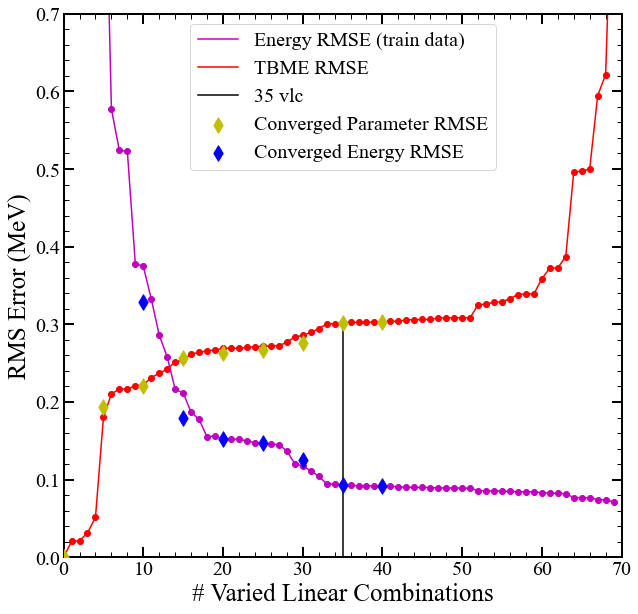

In [7]:
numBatches = 1      # Number of batches of data to include in the set of fits
numVLC = 35         # Number of VLC of parameters for the output hamiltonian
dataPercent = 1.0   # Percent of data to include in each training batch
testRMSE, trainRMSE, pRMSE, outputHamiltonian, eTheory = allVLC(numBatches, dataPercent, numVLC)

# For a given number of singular values, calculate the averave RMSE across batches
eRMSEaverageTest = np.empty(len(abinitioHam)+1)
eRMSEaverageTrain = np.empty(len(abinitioHam)+1)
pRMSEaverage = np.empty(len(abinitioHam)+1)
tbmeRMSE = scipy.linalg.norm(abinitioHam - outputHamiltonian)/math.sqrt(len(abinitioHam))
for i in range(len(abinitioHam)+1):
    eRMSEaverageTest[i] = np.sum(testRMSE[:,i])/numBatches
    eRMSEaverageTrain[i] = np.sum(trainRMSE[:,i])/numBatches
    pRMSEaverage[i] = np.sum(pRMSE[:,i])/numBatches

x = [i for i in range(len(abinitioHam)+1)] 
#f = plt.figure()
f, ax = plt.subplots()
f.set_figwidth(10)
f.set_figheight(10)
for location in ['left', 'right', 'top', 'bottom']:
    ax.spines[location].set_linewidth(2)
if numBatches > 10:
    alphaValue = 10/numBatches
else:
    alphaValue = 1
for i in range(numBatches):
    plt.scatter(x, trainRMSE[i], color='m', alpha=alphaValue)
    plt.scatter(x, pRMSE[i], color='r', alpha=alphaValue)
    if dataPercent < 1.0:
        plt.scatter(x, testRMSE[i], color='g', alpha=alphaValue)
plt.plot(x, eRMSEaverageTrain, label='Energy RMSE (train data)', color='m')
plt.plot(x, pRMSEaverage, label='TBME RMSE', color='r')
if dataPercent < 1.0:
    plt.plot(x, eRMSEaverageTest, label='Energy RMSE (test data)', color='g')
convergedX = [0, 5,10,15,20,25,30,35,40]
convergedERMSE = [2.5, 0.779, 0.329, 0.179, 0.152, 0.147, 0.125, 0.093, 0.092]
convergedPRMSE = [0.0, 0.194, 0.221, 0.257, 0.263, 0.267, 0.276, 0.302, 0.303]
plt.scatter(convergedX, convergedPRMSE, label='Converged Parameter RMSE', c='y', marker="d", s=120, zorder=4)
plt.scatter(convergedX, convergedERMSE, label='Converged Energy RMSE', c='b', marker="d",s=120, zorder=5)
plt.axvline(x = numVLC, ymin = 0, ymax = tbmeRMSE/0.7, color = 'k', label = '%i vlc' %numVLC)
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
#plt.title('r35 SVD Fit For %i Batch(es) of Data' %numBatches, fontsize=25)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="major", direction="in", right=True, top=True, length=10, width=2, labelsize=20)
plt.tick_params(which="minor", direction="in", right=True, top=True, length=5, width=1, labelsize=20)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20).set_alpha(1)
plt.legend(fontsize=20).set_alpha(1)
plt.show()

The red curve is the RMSE between our starting hamiltonian parameter values and our fitted values at each number of varied linear combinations of parameters (VLC's) - in other words for each number of singular values of the inverted design matrix chosen to weight the starting linear combinations of parameters.

The magenta curve is the RMSE due only to residuals between the data used to fit (train) the Hamiltonian parameters before and after the fit.
The green curve is the RMSE due only to the residuals between the data outside of the training sets (test data) before and after the fit. 
The blue curve is the RMSE due to the residual between all data (test and training) before and after the fit.

Each point represents the respective parameter and energy RMSE for converged Hamiltonians. The starting interaction was used to generate wavefunctions and corresponding energy spectra, and a SVD was performed on this input Hamiltonian with a given number of singular values (and corresponding VLC's) fitted to experimental data, resulting in a new Hamiltonian. This fitted Hamiltonian was used to generate new wavefunctions/spectra and the fit was repeated - this cycle continues until the Hamiltonian parameters in the fit do not change from the previous fitting iteration. 

[-0.11706128696629747, 0.29854685178586193, 0.002495630526456738, 0.07294267399511511, 0.05276073462461106, 0.014681331726055902, -0.03547642333313483, 0.009134978877028743, 0.18367406197266578, -0.14059196176688105, 0.17765218763303214, -0.04737431880944287, 0.13790554833708057, 0.227496449739504, 0.14058129791610652, -0.02250038514328878, 0.3113061607690306, -0.1657480425806317, -0.04116468762412495, 0.05968847189158266, 0.064752610339184, -0.18317878605707666, 0.2586690937341849, -0.0603480908750198, -0.02274676126512687, -0.07630914760855045, 0.09730445148244371, 0.27789676698394405, 0.17260484110295238, 0.07126624814848892, -0.1707944688224945, -0.24207988947057624, -0.09337913875671688, 0.11298309795093253, -0.032641940110291756, -0.11905760993132763, -0.07602233400612834, -0.0937022557541507, -0.02367875036670486, 0.061722420071568695, -0.11154061196268827, 0.2132629479455428, -0.1667115239032495, 0.1613316709188819, -0.024187950603263175, 0.06283123096021859, -0.011616778837198

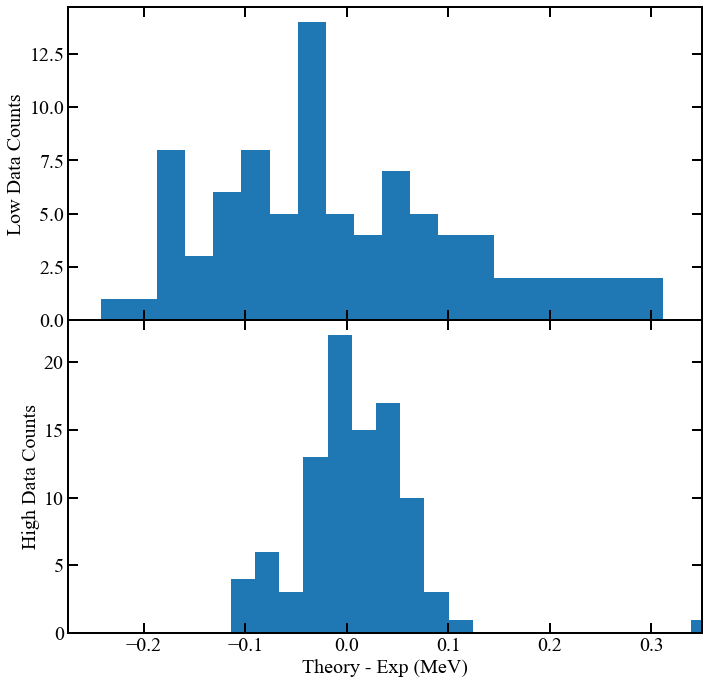

In [8]:
# Be sure to set numBatches = 1 and dataPercent = 1.0 before running this cell
lowResiduals = []
highResiduals = []
for i in range(103):
    if error[i] < 1.0:
        lowResiduals.append(eTheory[i]-exp[i])
for i in range(103,len(exp)):
    if error[i] < 1.0:
        highResiduals.append(eTheory[i]-exp[i])
print(lowResiduals,)
f, ax = plt.subplots(nrows=2, ncols=1)
for location in ['left', 'right', 'top', 'bottom']:
    ax[0].spines[location].set_linewidth(2)
    ax[1].spines[location].set_linewidth(2)
ax[0].hist(lowResiduals, bins=20)
ax[1].hist(highResiduals, bins=20)
f.set_figwidth(10)
f.set_figheight(10)
ax[1].set_xlabel('Theory - Exp (MeV)', fontsize=20)
ax[0].set_ylabel('Low Data Counts', fontsize=20)
ax[1].set_ylabel('High Data Counts', fontsize=20)
ax[0].set_xlim(left=-0.275, right=0.35)
ax[1].set_xlim(left=-0.275, right=0.35)

f.tight_layout()
f.subplots_adjust(hspace=0.0, top=0.95)
ax[0].tick_params(which="major", direction="in", right=True, top=True, length=10, width=2, labelsize=20)
ax[1].tick_params(which="major", direction="in", right=True, top=True, length=10, width=2, labelsize=20)
plt.show()

In [70]:
outputs1 = np.array([abinitioHam, outputHamiltonian])
with open("Test.dat","w") as f:
    f.write("Parameters of VLC=35 Fit: \n")
    f.write("background         fit \n")
    #np.savetxt(f, outputs1.T, delimiter=' ', fmt='%s')
    np.savetxt(f, outputs1.T, delimiter='     ', fmt='%10.4f')

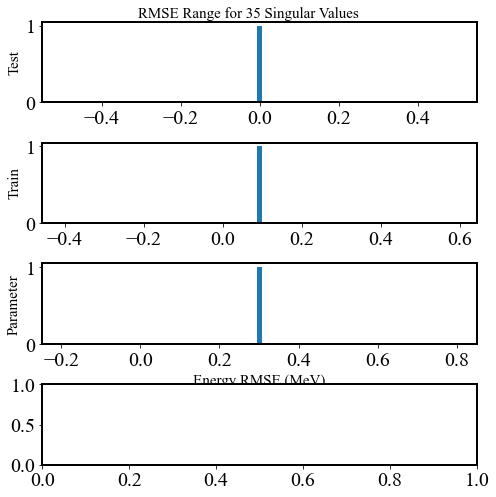

In [6]:
nSVD = 35
fs = 15
nBins = 75
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(7,7))

axs[0].hist(testRMSE[:,nSVD], bins=nBins)
axs[1].hist(trainRMSE[:,nSVD], bins=nBins)
axs[2].hist(pRMSE[:,nSVD], bins=nBins)
axs[2].set_xlabel('Energy RMSE (MeV)', fontsize=fs)
axs[0].set_ylabel('Test', fontsize=fs)
axs[1].set_ylabel('Train', fontsize=fs)
axs[2].set_ylabel('Parameter', fontsize=fs)
#axs[0].grid(True)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5, top=0.95)
plt.suptitle("RMSE Range for %i Singular Values" %nSVD, fontsize=fs)
plt.show()

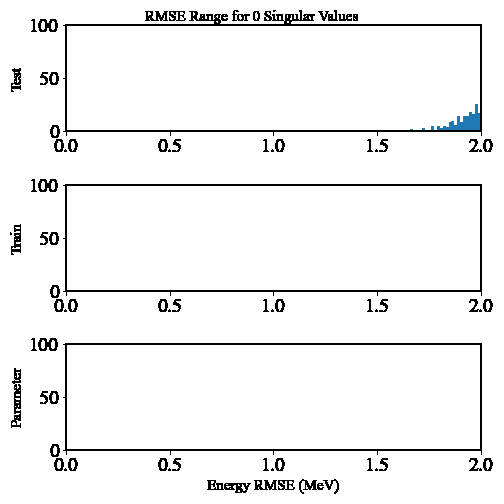

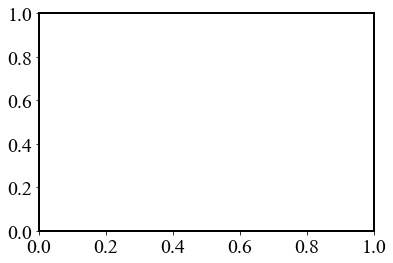

In [20]:
frame, axes = plt.subplots()
fs = 15
nBins = 75
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,7))
def animate(i):
    axs[0].clear()
    axs[1].clear()
    axs[2].clear()
   
    axs[0].hist(testRMSE[:,i], bins=nBins)
    axs[1].hist(trainRMSE[:,i], bins=nBins)
    axs[2].hist(pRMSE[:,i], bins=nBins)

    axs[2].set_xlabel('Energy RMSE (MeV)', fontsize=fs)
    axs[0].set_ylabel('Test', fontsize=fs)
    axs[1].set_ylabel('Train', fontsize=fs)
    axs[2].set_ylabel('Parameter', fontsize=fs)

    axs[0].set_xlim(left=0, right=2.0)
    axs[1].set_xlim(left=0, right=2.0)
    axs[2].set_xlim(left=0, right=2.0)
    axs[0].set_ylim(bottom=0, top=100)
    axs[1].set_ylim(bottom=0, top=100)
    axs[2].set_ylim(bottom=0, top=100)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.95)
    fig.suptitle(t='', fontsize=fs).set_text("RMSE Range for {} Singular Values".format(i))
  
ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(x), interval=250)
f = r'batchAnimation80p.gif'
writergif = animation.PillowWriter(fps=8)
ani.save(f,writer=writergif)
plt.close()
Image(open('batchAnimation80p.gif','rb').read())

In [35]:
diffScale = []
rmsLow = []
rmsHigh = []
rmsTot = []
mseLow = 0.0
lowCount = 0
mseHigh = 0.0
highCount = 0
allErrors = eTheory - exp
for i in range(len(exp)):
    thisSquaredError = allErrors[i]**2
    if i < 103:
        if error[i] < 1.0:
            lowCount += 1
            mseLow += thisSquaredError
    if i >= 103:
        if error[i] < 1.0:
            highCount += 1
            mseHigh += thisSquaredError
    if lowCount == 0:
        rmsLow.append(0.0)
    if lowCount > 0:
        rmsLow.append(math.sqrt(mseLow/lowCount))
    if highCount == 0:
        rmsHigh.append(math.sqrt(0.0))
    if highCount > 0:
        rmsHigh.append(math.sqrt(mseHigh/highCount))
    if (lowCount + highCount) == 0:
        currentRMS = math.sqrt(0.0)
    if (lowCount + highCount) > 0:
        currentRMS = math.sqrt((mseLow + mseHigh)/(lowCount + highCount))
    rmsTot.append(currentRMS)
rmsHighNP = np.array(rmsHigh)
rmsLowNP = np.array(rmsLow)
rmsTotNP = np.array(rmsTot)
    
for i in range(len(eTheory)):
    numSymbols = int((eTheory[i]-exp[i])/0.1)
    if numSymbols < 0.0:
        symbol = '-'
    if numSymbols > 0.0:
        symbol = '+'
    if error[i] > 1.0:
        symbol = 'o'
    thisDiff = ""
    for j in range(abs(numSymbols)):
        thisDiff += symbol
    diffScale.append(thisDiff)

outputs2 = np.array([nuclei, error, exp, eTheory, eTheory-exp, diffScale, rmsTot, rmsLow, rmsHigh])
with open("expfit.dat","w") as f:
    f.write("nuc     error      exp      theory      difference\n")
    #np.savetxt(f, outputs1.T, delimiter=' ', fmt='%s')
    np.savetxt(f, outputs2.T, delimiter='     ', fmt='%2s %10.4f %10.4f %10.4f %10.4f %-12s %10.4f %10.4f %10.4f')